# HW2 GARCH 실습
---

- 실습 내용을 전력 데이터로 진행해보자.
- HW1 에서 전력데이터는 ARIMA로 수월하게 적합하지 못했다.
  - 특히 변동 폭이 커지는 것을 잡지 못하였음
- 이점을 GARCH로 보완할 수 있는지 파악해보자.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [4]:
ele = pd.read_csv("data/ele_val_output_7.csv").iloc[:,1:].values.flatten() / 10000


# 로그변환 및 차분
---

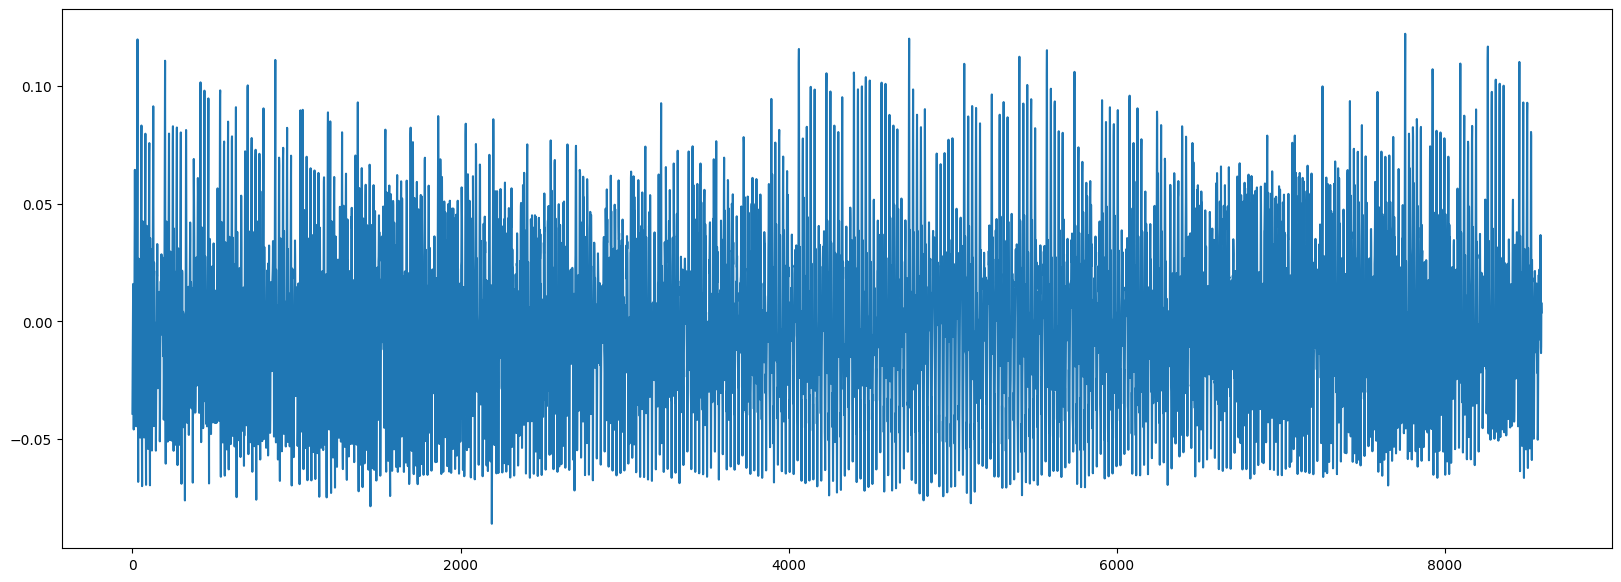

In [10]:
plt.figure(figsize = (20,7))
plt.plot(np.log(ele)[1:] - np.log(ele)[:-1])
plt.show()

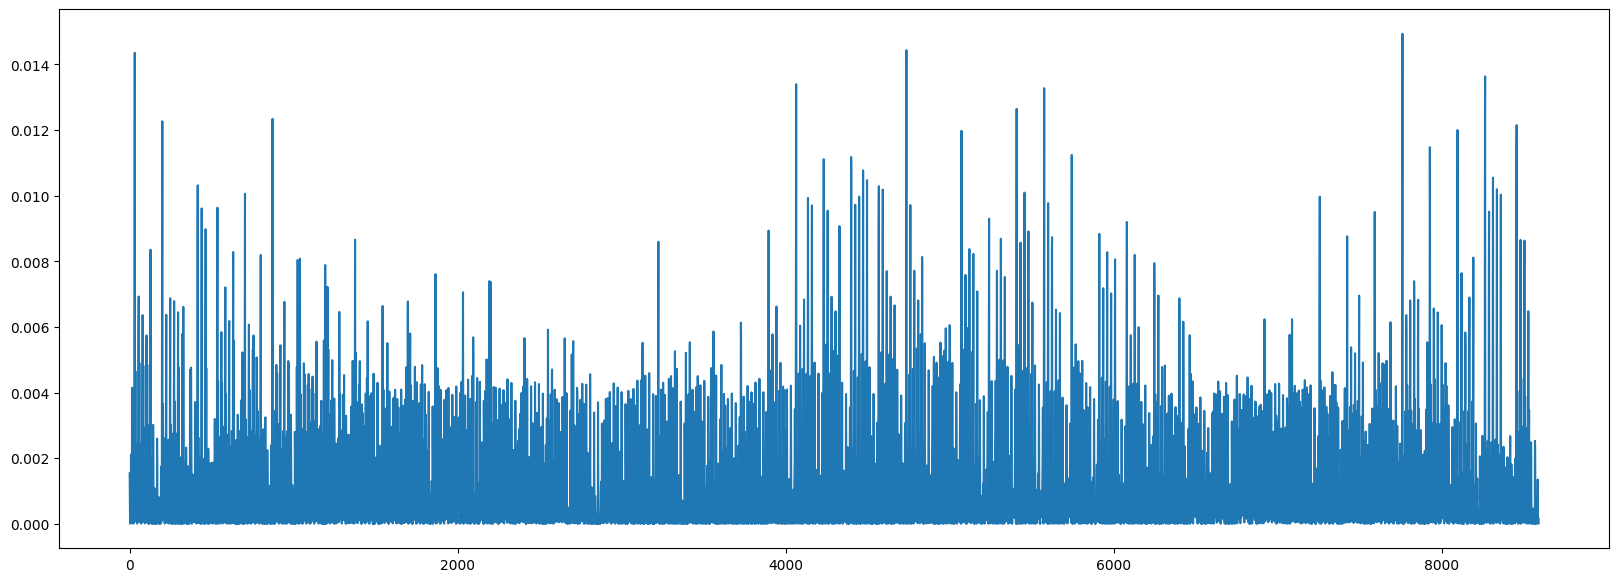

In [13]:
plt.figure(figsize = (20,7))
plt.plot((np.log(ele)[1:] - np.log(ele)[:-1])**2)
plt.show()

- 이분산 매우 강하게 나타남

# ACF, PACF 확인
---

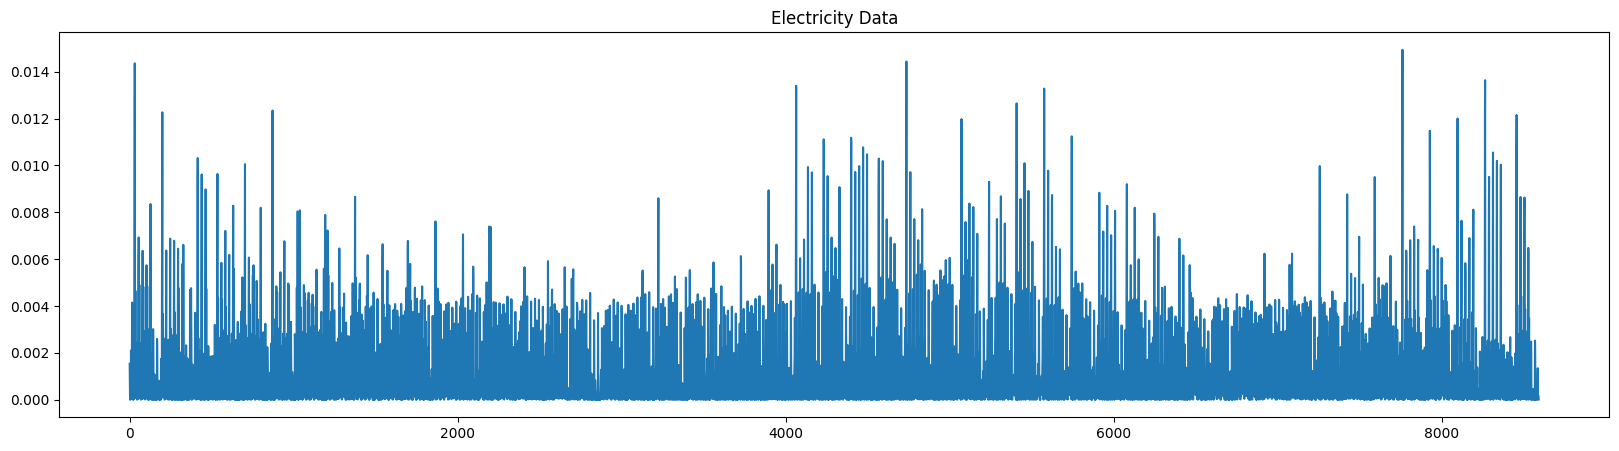

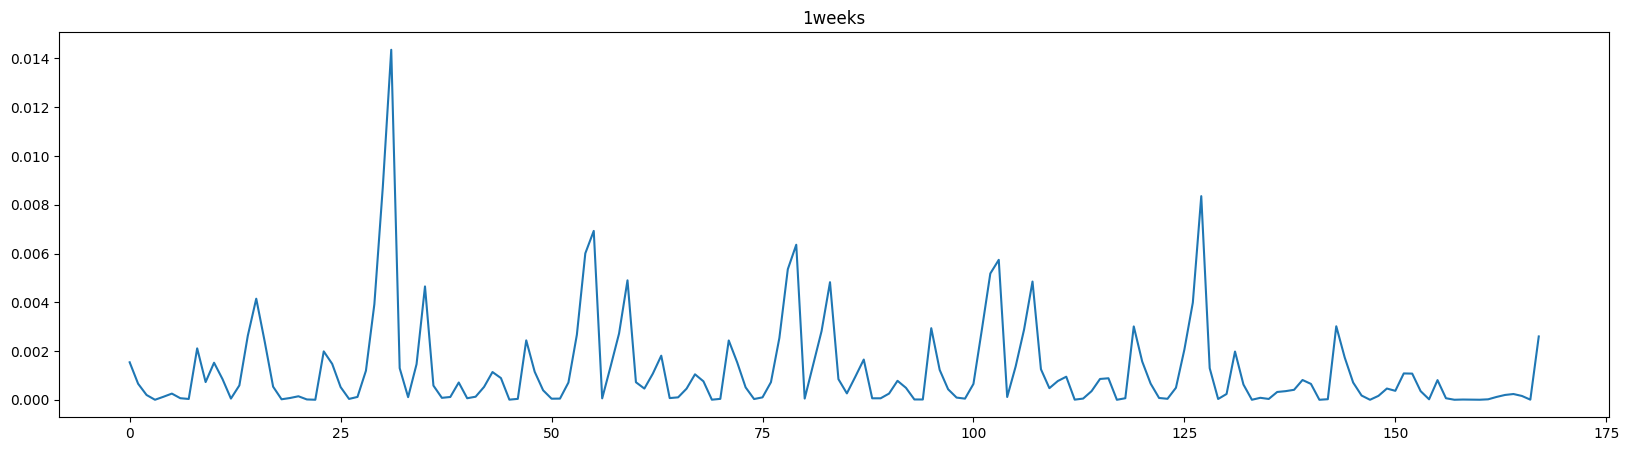

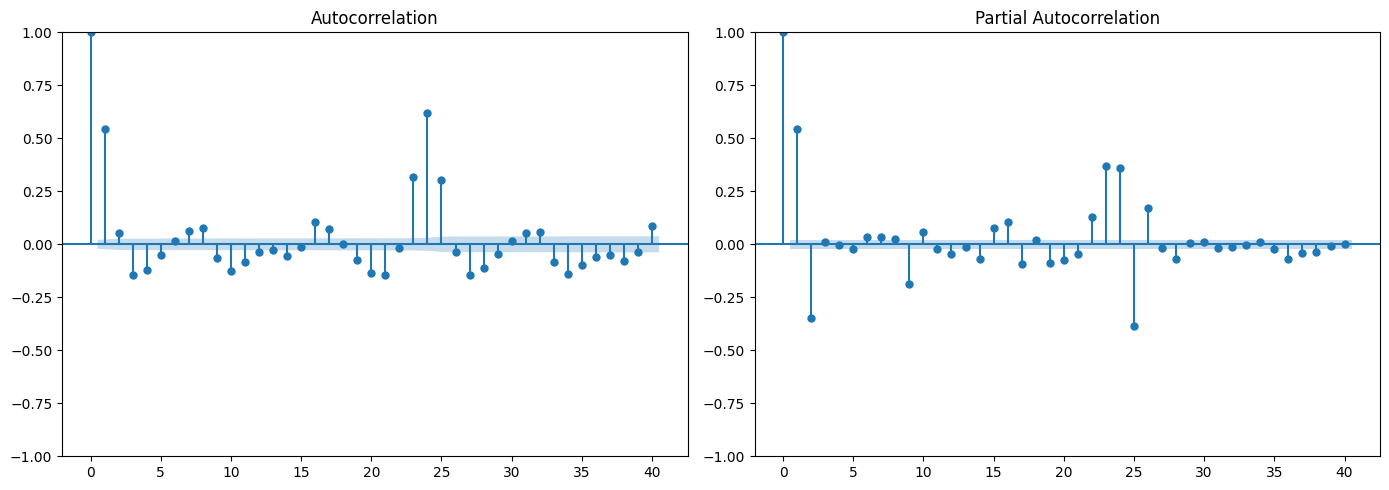

In [15]:
ele=(np.log(ele)[1:] - np.log(ele)[:-1])**2
plt.figure(figsize=(20,5))
plt.plot(ele)
plt.title("Electricity Data")
plt.show()

plt.figure(figsize=(20,5))
plt.plot(ele[:24*7])
plt.title("1weeks")
plt.show()

plt.figure(figsize=(14,5))
plt.subplot(121)
plot_acf(ele, lags=40, ax=plt.gca())
plt.subplot(122)
plot_pacf(ele, lags=40, ax=plt.gca())
plt.tight_layout()
plt.show()

In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model

# 예시 데이터 생성 (실제 데이터로 교체 필요)
ele = pd.read_csv("data/ele_val_output_7.csv").iloc[:,1:].values.flatten() / 10000

ele=ele[:24*100]
# 1단계: SARIMAX 모델 적합
sarimax_model = SARIMAX(ele[:-24], 
                        order=(2, 1, 3),                # (p, d, q)
                        seasonal_order=(2, 0, 1, 24),   # (P, D, Q, s)
                        enforce_stationarity=False,
                        enforce_invertibility=False)
sarimax_results = sarimax_model.fit(disp=False)

# SARIMAX 모델의 잔차 계산
residuals = sarimax_results.resid

# 2단계: GARCH 모델 적용 (잔차에 대해 GARCH(1,1) 설정)
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_results = garch_model.fit(disp="off")

# 결과 요약 출력
print("SARIMAX 결과 요약:")
print(sarimax_results.summary())
print("\nGARCH 결과 요약:")
print(garch_results.summary())

/home/student/anaconda3/envs/py310/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX 결과 요약:
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 2376
Model:             SARIMAX(2, 1, 3)x(2, 0, [1], 24)   Log Likelihood                2653.469
Date:                              Wed, 30 Oct 2024   AIC                          -5288.938
Time:                                      15:48:20   BIC                          -5237.175
Sample:                                           0   HQIC                         -5270.076
                                             - 2376                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8592      0.069     12.436      0.000       0.724       0.995
ar.L

/home/student/anaconda3/envs/py310/lib/python3.10/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03513. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


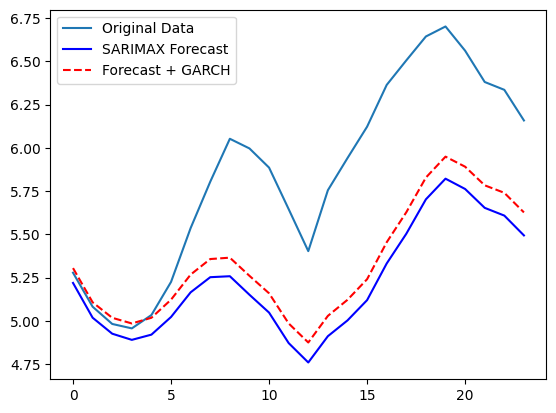

In [46]:
forecast_sarimax = sarimax_results.get_forecast(steps=24)
forecast_mean = forecast_sarimax.predicted_mean  # 평균 예측 값

# SARIMAX 모델의 잔차 계산
residuals = sarimax_results.resid

# GARCH 모델을 사용해 향후 24시점에 대한 분산(변동성) 예측
garch_forecast = garch_results.forecast(horizon=24)
forecast_variance = garch_forecast.variance.values[-1, :]  # 분산 예측 값
# 원본 데이터와 SARIMAX 예측
plt.plot(ele[-24:],label='Original Data')
plt.plot(forecast_mean, label='SARIMAX Forecast', color='blue')\
# GARCH 예측 분산을 활용한 변동성 시각화
plt.plot(forecast_mean + np.sqrt(forecast_variance), 
         color='red', linestyle='--', label='Forecast + GARCH')

plt.legend()
plt.show()

`-` 모형식 

$$
\Phi_2(B^{24}) \phi_2(B) (1 - B) y_t = \Theta_1(B^{24}) \theta_3(B) \varepsilon_t
$$
$$
\varepsilon_t = \sigma_t z_t, \quad z_t \sim \mathcal{N}(0,1)
$$
$$
\sigma_t^2 = \omega + \alpha_1 \varepsilon_{t-1}^2 + \beta_1 \sigma_{t-1}^2
$$

# 시뮬레이션 데이터 생성
$ARCH(1)$

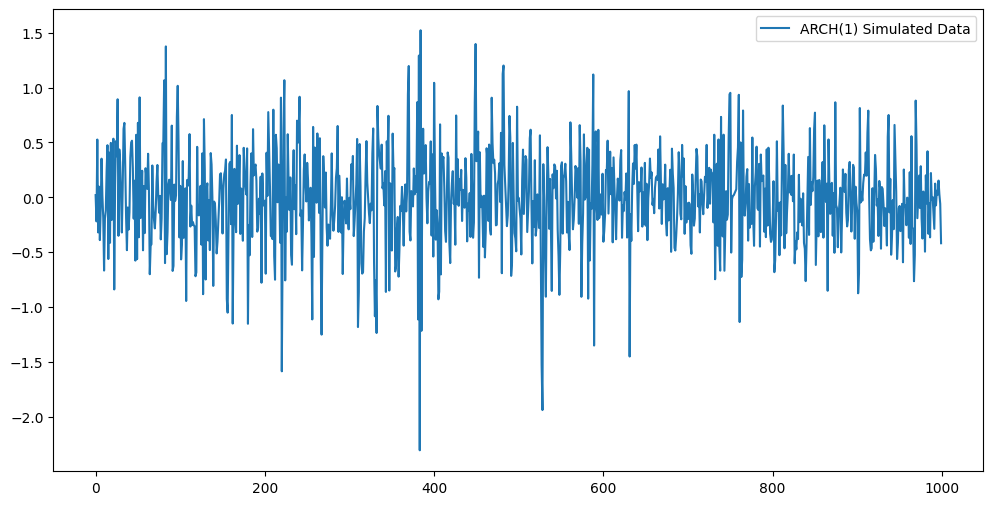

In [56]:

def arch_simulate(arch_coef, const, length=1000):
    epsilon = np.zeros(length)
    sigma2 = np.zeros(length)

    sigma2[0] = const / (1 - arch_coef)
    epsilon[0] = np.random.normal(0, np.sqrt(sigma2[0]))

    for t in range(1, length):
        sigma2[t] = const + arch_coef * epsilon[t-1]**2
        epsilon[t] = np.random.normal(0, np.sqrt(sigma2[t]))

    return epsilon


arch_coef = 0.5
const = 0.1
length = 1000

simulated_data = arch_simulate(arch_coef, const, length=length)
plt.figure(figsize=(12, 6))
plt.plot(simulated_data, label='ARCH(1) Simulated Data')
plt.legend()
plt.show()
